<a href="https://colab.research.google.com/github/IamShivamJaiswal/sign-board/blob/master/transliteration/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

## Clone the repository

for data

In [2]:
!git clone https://github.com/Karveandhan/signboardtranslitation

Cloning into 'signboardtranslitation'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [3]:
from __future__ import absolute_import, division, print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import io
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import time

2.5.0


## Preprocessing

1. Add a *start* as `0` and *end* as `1` token to each sentence.
2. Clean the sentences by removing special characters.


In [4]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace('-', ' ').replace(',', ' ')
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '0' + w + '1'
    return w.split()
  
def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace('-', ' ').replace(',', ' ')
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
        
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '0' + w + '1'
    return w.split()

In [5]:
word = "FARIHAH"
hindi = "फरीहाह"
print(preprocess_sentence(word))
print(preprocess_sentence_hindi(hindi))

['0farihah1']
['0फरीहाह1']


In [6]:
import xml.etree.ElementTree as ET
def create_dataset(filename):

    transliterationCorpus = ET.parse(filename).getroot()
    lang1_words = []
    lang2_words = []

    for line in transliterationCorpus:
                wordlist1 = preprocess_sentence(line[0].text) # clean English words.
                wordlist2 = preprocess_sentence_hindi(line[1].text)# clean hindi words.
                
                #to check consistency in the input vs output mapping
                if len(wordlist1) != len(wordlist2):
                    print('Skipping: ', line[0].text, ' - ', line[1].text)
                    continue

                for word in wordlist1:
                    lang1_words.append(word)
                for word in wordlist2:
                    lang2_words.append(word)
    return [lang1_words,lang2_words]

In [7]:
PATH = "/content/signboardtranslitation/transliteration/data/"

train_data = create_dataset(PATH+'NEWS2012TrainingEnHi.xml')
test_data = create_dataset(PATH+'NEWS2012TestingEnHi1000.xml')

Skipping:  BUSHNELL'S MUSEUM  -  बुशनेल्स म्युज़ियम
Skipping:  I^DUKAANT  -  इंदुकांत
Skipping:  THE AUSTRALIAN/VOGEL LITERARY AWARD  -  द ऑस्ट्रेलियन/वोगेल लिट्रेरी अवार्ड
Skipping:  PLAZA 66  -  प्लाज़ा 66
Skipping:  Bhaalachan_dr  -  भालचन्द्र
Skipping:  MAN OF THE YEAR/PERSON OF THE YEAR  -  मैन ऑफ द ईयर/पर्सन ऑफ द ईयर
Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  QUEEN ANNE'S WAR  -  क्वीन एनीज वार
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  IN_DRAJEET  -  इन्द्रजीत
Skipping:  SAINT FRANCIS D'ASSISI HIGH SCHOOL  -  सेंट फ्रांसिस ड‍िअस‍ीसी हाई स्कूल
Skipping:  SHU'A  -  शुआ
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  I^diyaa  -  इंडिया
Skipping:  DAI'EI  -  दैई
Skipping:  ISMA'IL  -  इस्मा'ईल
Skipping:  WOMEN'S LITERATURE PRIZE  -  वुमेन्स लिट्रेचर प्राइज़
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  BRAJEN_DR  -  ब्रजेन्द्र
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  LU'LU  -  लु'लु
Skipping:  CHITTAR RESERVOIR-

In [8]:
train_data[0][:10],train_data[1][:10]

(['0raasavihaaree1',
  '0deogan',
  'road1',
  '0shatrumardan1',
  '0mahijuba1',
  '0sabine1',
  '0bill',
  'cosby1',
  '0rishta',
  'kagaz'],
 ['0रासविहारी1',
  '0दवगन',
  'रोड1',
  '0शतरमरदन1',
  '0महिजबा1',
  '0सबिन1',
  '0बिल',
  'कॉसबी1',
  '0रिशता',
  'कागज'])

In [9]:
print(len(train_data[0]),len(train_data[1]))

20382 20382


In [10]:
class WordIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      for l in phrase:
        self.vocab.update(l)
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word
      

In [11]:
def tokenize(lang):
  index_lang  = WordIndex(lang)
  input_tensor = [[index_lang.word2idx[s] for s in en] for en in lang]
  max_length = max(len(t) for t in input_tensor)
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length,
                                                                 padding='post')
  return input_tensor, index_lang , max_length

In [12]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(pairs):


    # index language using the class defined above    
    targ_lang, inp_lang = pairs[1],pairs[0]
    
    input_tensor, inp_lang_tokenizer ,max_length_inp = tokenize(inp_lang)
    
    target_tensor, targ_lang_tokenizer,max_length_tar = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer,max_length_inp,max_length_tar

In [13]:
input_tensor, target_tensor, inp_lang, targ_lang,max_length_inp, max_length_targ = load_dataset(train_data)

In [14]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.idx2word[t]))

In [15]:
convert(inp_lang,input_tensor[-1])
convert(targ_lang,target_tensor[-1])

6 ----> b
19 ----> o
24 ----> t
12 ----> h
5 ----> a
17 ----> m
3 ----> 1
40 ----> ब
55 ----> ो
34 ----> थ
42 ----> म
5 ----> 1


In [16]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.05)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(19362, 19362, 1020, 1020)

In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)+1
vocab_tar_size = len(targ_lang.word2idx)+1

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 22]), TensorShape([128, 16]))

In [20]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [21]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 22, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


In [22]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 22, 1)


In [24]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)


    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((128, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 60)


## Define the optimizer and the loss function

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask*1.5

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training


In [28]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word2idx['0']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [29]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8709
Epoch 1 Batch 100 Loss 1.2916
Epoch 1 Loss 1.3443
Time taken for 1 epoch 78.09786629676819 sec

Epoch 2 Batch 0 Loss 1.0966
Epoch 2 Batch 100 Loss 0.4196
Epoch 2 Loss 0.5412
Time taken for 1 epoch 55.01482176780701 sec

Epoch 3 Batch 0 Loss 0.3027
Epoch 3 Batch 100 Loss 0.2400
Epoch 3 Loss 0.2978
Time taken for 1 epoch 54.585477113723755 sec

Epoch 4 Batch 0 Loss 0.2334
Epoch 4 Batch 100 Loss 0.2524
Epoch 4 Loss 0.2283
Time taken for 1 epoch 54.910236835479736 sec

Epoch 5 Batch 0 Loss 0.2375
Epoch 5 Batch 100 Loss 0.1873
Epoch 5 Loss 0.1894
Time taken for 1 epoch 54.60859680175781 sec

Epoch 6 Batch 0 Loss 0.1480
Epoch 6 Batch 100 Loss 0.1677
Epoch 6 Loss 0.1685
Time taken for 1 epoch 54.93698215484619 sec

Epoch 7 Batch 0 Loss 0.1493
Epoch 7 Batch 100 Loss 0.1694
Epoch 7 Loss 0.1421
Time taken for 1 epoch 54.66484808921814 sec

Epoch 8 Batch 0 Loss 0.1339
Epoch 8 Batch 100 Loss 0.1298
Epoch 8 Loss 0.1278
Time taken for 1 epoch 54.8728711605072 sec

Epoch 9

## Translitrate


In [30]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)[0]

    inputs = [inp_lang.word2idx[i] for i in sentence]

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['0']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '1':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [31]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [32]:
def translitrate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence[1:-1]))
    print('Predicted translation: {}'.format(''.join(result.split(' '))[:-1]))

    attention_plot = attention_plot[:len(result.split(' ')), :len(list(sentence))]
    plot_attention(attention_plot, list(sentence), result.split(' '))
    

## Restore the latest checkpoint and test

In [33]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: coimbatore
Predicted translation: कोइमबटर


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2311 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2348 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2335 missing from current font.
  font.set_text(s

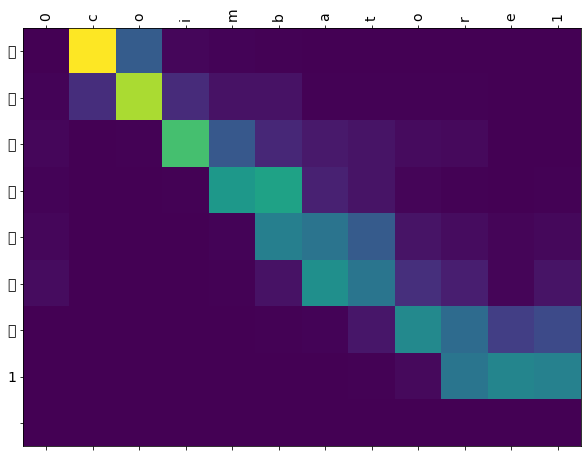

In [41]:
translitrate('Coimbatore')

Input: bhatnagar
Predicted translation: भटनागर


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2349 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2335 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s

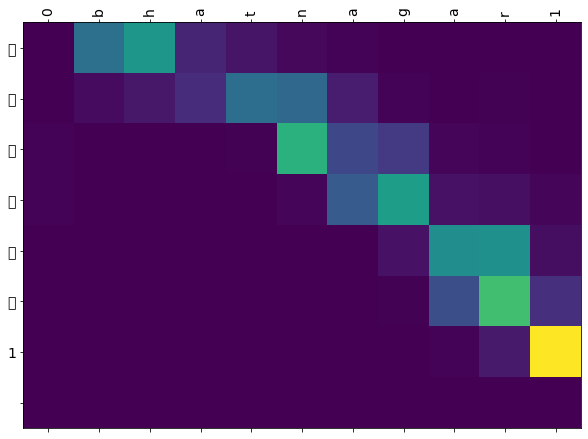

In [35]:
translitrate('bhatnagar')

Input: adams
Predicted translation: एडमस


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2319 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2337 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2319 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2337 missing from current font.
  font.set_text(s, 

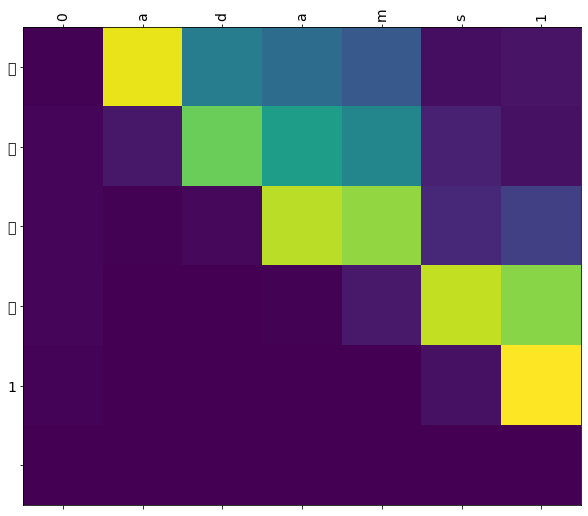

In [36]:
translitrate("Adams")

## Exact Match Accuracy

In [37]:
def lcs(X, Y): 
    # find the length of the strings 
    m = len(X) 
    n = len(Y) 
  
    # declaring the array for storing the dp values 
    L = [[None]*(n + 1) for i in range(m + 1)] 
  
    """Following steps build L[m + 1][n + 1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
  
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1] 
    return L[m][n] 

In [38]:
def exactmatch(predict,actual):
  
  #length of Longest Common Subsequence
  l = lcs(predict,actual)
  
  return l / len(actual)

In [39]:
len(test_data[0])

1000

In [40]:
tot = 0.0 
for i in range(len(test_data[0])):
  inputstr , resultstr = test_data[0][i][1:-1],test_data[1][i][1:-1]
  result,_,_ = evaluate(inputstr)
  temppredict = ''.join(result.split(' '))[:-1]
  acc = exactmatch(temppredict,resultstr)
  tot = tot + acc
  print(inputstr,resultstr,temppredict,acc)
print("Average acuracy :",tot/len(test_data[0]))  

aadhi आधी आधी 1.0
aakash आकाश आकाश 1.0
aap आप आप 1.0
aayasha आयशा आयाशा 1.0
aayee आई आईय 1.0
abduh अबदस अबदह 0.75
aberhart एबरहरट अबरहारट 0.8333333333333334
abey अबय एबी 0.3333333333333333
abou अब अबो 1.0
abri एबरी अबरी 0.75
academy अकडमी एकडमी 0.8
accommodation एकोमडशन एकोमोडशन 1.0
acorn एकोरन आकोरन 0.8
adams एडमस एडमस 1.0
adgaon अदगाव अदगाव 1.0
adlabs एडलबस एडलाबस 1.0
agro एगरो एगरो 1.0
ahlaad आहलाद आहलाद 1.0
air एअर एयर 0.6666666666666666
aisin एसिन ऐसिन 0.75
ajee अजी अजी 1.0
ajhai अझाई अजहई 0.5
ajith अजीथ अजिथ 0.75
akaram अकरम आकाराम 0.75
akele अकल एकल 0.6666666666666666
akhri आखिरी अखिरी 0.8
akodia अकोडिया एकोडिया 0.8571428571428571
akurdi अकरडी अकरदी 0.8
alas अलास एलास 0.75
albany अलबान एलबनी 0.6
alester एलसटर एलसटर 1.0
alex एलकस एलकस 1.0
alipur अलीपर अलीपर 1.0
alkali अलकली अलकली 1.0
alpesh अलपश अलपश 1.0
amanat अमानत अमात 0.8
american अमरिकन अमरिकन 1.0
amodini अमोदिनी अमोदिनी 1.0
andha अधा अधा 1.0
angel एजल एजल 1.0
anna अनना एना 0.5
anne एनी एनी 1.0
antibody एटीबॉडी एटीबॉडी 1.0
a